In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.stats import multivariate_normal

# The Harmonic Interaction Model

### The N-body probabilty distribution function (PDF)

\begin{align} 
P_m &\equiv P(r_1,r_2,\ldots,r_m) = \left|\Psi\left(r_1,r_2,\ldots,r_N\right)\right|^2 \\
&= \left(\frac{\delta_N}{\pi}\right)^{\frac{dm}{2}}\left(\frac{N\omega}{(N-m)\omega +m\delta_N}\right)^{\frac{d}{2}}\exp\left(-\frac{1}{N}\left(\omega+(N-1)\delta_N\right)\sum_{i=1}^mr_i^2-\frac{2}{N}
\sum_{i<j}^mr_ir_j-C_m\left(\sum_{i=1}^mr_i\right)^2\right)
\end{align}


#### where
\begin{equation*}
C_m = -\frac{1}{N}\frac{(N-m)(\omega-\delta_N)^2}{(N-m)\omega + m \delta_N} 
\end{equation*}

### Probability "Chain Rule"

\begin{equation*}
P(r_1,r_2,\ldots,r_m) = P(r_1)P(r_2|r_1)\cdots P(r_m|r_1,r_2,\ldots,r_{m-1})
\end{equation*}

### The conditional probability

\begin{align} 
P(r_m|r_1,r_2,\ldots,r_{m-1}) &= \frac{P(r_1,r_2,\ldots,r_m)}{P(r_1,r_2,\ldots,r_{m-1})}= \frac{P_m}{P_{m-1}}\\ &= \left(\frac{\delta_N}{\pi}\right)^{\frac{d}{2}}\left(1 + \frac{\omega-\delta_N}{(N-m)\omega +m\delta_N}\right)^{\frac{d}{2}}\exp\left(-\frac{1}{N}(\omega+(N-1)\delta_N)r_m^2 -\frac{1}{N}r_m\sum_{i=1}^{m-1}r_i\right)\\
&\times\exp\left( -C_mr_m^2-2C_mr_m\sum_{i=1}^{m-1}r_i-\left(\sum_{i=1}^{m-1}r_i\right)^2\left(C_m-C_{m-1}\right) \right) \\
&= \frac{1}{\sqrt{2\pi\sigma_m^2}}\exp\left(-\frac{\left(r_m-\mu_m\right)^2}{2\sigma_m^2} \right)
\end{align}


#### where
\begin{equation*}
\mu_m = \frac{\omega-\delta_N}{(m-1)\delta_N+(1-m+N)\omega}\sum_{i=1}^{m-1}r_i 
\end{equation*}
\begin{equation*}
\sigma_m^2 = \frac{m(\delta_N-\omega)+N\omega}{2\delta_N\left((m-1)\delta_N+(1-m+N)\omega\right)} 
\end{equation*}



In [20]:
class HIM: 
    """
    Class for creating the Quantum Ground State of the one dimensional 
    Bosonic Harmonic Interaction Model (HIM)
    see J. Math. Phys. 26(12), 3105, (1985).
    
    Parameters
    -----------
    N - Number of Bosons.
    omega - Frequency of the single particle harmonic confinement potential.
    lambda0 - Two body interaction parameter (= gamma^2 / 2 in the paper).
    """
    def __init__(self, N = 10, omega = 1, lambda0 = 0.1):
        self.N = N
        self.dimensions = 1
        self.omega = omega
        self.lambda0 = lambda0
        self.deltaN = np.sqrt(np.power(omega,2)+N*2*lambda0)
        self.KN = np.power(self.deltaN/np.pi,(self.dimensions/4)*(self.N-1))\
                * np.power(self.omega/np.pi,(self.dimensions/4))
        self.A = (1/(4*self.N))*((self.N-1)*self.deltaN + self.omega)
        self.B = (1/(4*self.N))*(self.omega - self.deltaN)
        # parameters for Rho1
        self.a1 = ((self.N-1.0)*(np.power(self.omega,2) + np.power(self.deltaN,2))
                + 2.0 * (np.power(self.N,2) - self.N + 1)*self.omega*self.deltaN)\
                / ((self.N-1.0)*self.omega+self.deltaN) / (4.0*self.N)
        self.a2 = (self.N-1)*np.power(self.omega-self.deltaN,2)\
                /((self.N-1.0)*self.omega+self.deltaN) / (2.0*self.N)
        # parameters for Rho2
        self.b1 = (1 / (4 * self.N)) * ((self.N - 2) * self.omega**2 + (3 * self.N - 2) * self.deltaN**2
                + 2 * (self.N**2 - 2 * self.N + 2) * self.omega * self.deltaN)\
                / ((self.N - 2) * self.omega + 2 * self.deltaN)
        self.b2 = (1 / (2 * self.N)) * ((self.N - 2) * self.omega**2 - (self.N + 2) * self.deltaN**2
                + 4 * self.omega * self.deltaN)\
                / ((self.N - 2) * self.omega + 2 * self.deltaN)
        self.b3 = (1 / (2 * self.N)) * ((self.N - 2) * (self.omega - self.deltaN)**2)\
                / ((self.N - 2) * self.omega + 2 * self.deltaN)
    def conditonalP(self,x,R,m):
        Pcond = np.sqrt(1.0/(2 * np.pi * self.var(m)))\
              * np.exp(-(x+self.mu(m)*R)**2/(2*self.var(m)))
        return Pcond
    def mu(self,m):
        mu = (self.omega - self.deltaN) / ((m - 1) * self.deltaN + (1 - m + self.N) * self.omega)
        return mu
    def var(self,m):
        var = m * (self.deltaN - self.omega) + self.N * self.omega
        var = var / (2 * self.deltaN * ((m - 1) * self.deltaN + (1 - m + self.N) * self.omega))
        return var
    def psiN(self,x):
        """ 
        The many-body wavefunction Psi(x1,x2,...,xN) 
        ---------------------------------------------
        Input - N-dimensional postion vector 
        Output - value of wavefunction 
        
        """
        if (self.N != len(x)):
            return('Wrong Input. The length of x must be {}'.format(self.N))
        wavefunction = self.KN * np.exp(- 2 * self.A * np.dot(x,x) 
                                   - 4 * self.B * (np.sum(np.sum(np.outer(x, x) - np.diag(x*x))))/2)
        return wavefunction
    def rho1(self, x, xp = 0.0, diag = True, normN = False): 
        """
        The one-body reduced density matrix
        -----------------------------------
        rho (x, xp)
        
        Input - two position values or mesh grid matrices
        Output - the density matrix over the input
        
        diag - flag to return only the boson density, i.e., x = xp
        normN - flag to normalize the boson density to N. 
        """
        if diag == True: # will return only the diagonal of the density matrix as a vector
            rho = np.exp(-self.a1*(np.power(x,2)+np.power(x,2))+self.a2*x*x)
        else: # return the full first order density matrix
            rho = np.exp(-self.a1*(np.power(x,2)+np.power(xp,2))+self.a2*x*xp)          
        rho = rho * np.power(self.deltaN * self.N * self.omega
                                              / np.pi / ((self.N-1)*self.omega+self.deltaN),self.dimensions/2)           
        if normN == True:
            rho = rho * self.N
        return rho
    def rho2(self, x1, x2, x1p = 0.0, x2p = 0.0, diag = True, normN = False): 
        """
        The two-body reduced density matrix
        -----------------------------------
        rho2 (x1, x2, x1p, x2p)
        
        Input - four position values
        Output - the second order reduced density over the input
        
        diag - flag to return only the diagonal of the two-body density, i.e., x1 = x1p, x2 = x2p
        normN - flag to normalize the second order density to N(N-1)/2. 
        """
        if diag == True: # will return only the diagonal of the density matrix as a vector
            rho = np.exp(-2 * self.b1*(np.power(x1,2) + np.power(x2,2))
                        - 2 * self.b2 * (x1 * x2) + self.b3 * (np.power(x1,2) + np.power(x2,2) +2 * x1 * x2))
        else: # return the full first order density matrix
            rho = 0
        rho = rho * np.power(self.deltaN**2 * self.N * self.omega
                                              / np.pi**2 / ((self.N-2)*self.omega+2*self.deltaN),self.dimensions/2) 
        if normN == True:
            rho = rho * self.N * (self.N - 1) / 2
        return rho
    def rhoN(self, x, xp = 0.0, diag = True): 
        """
        The N-body density matrix
        -------------------------
        rhoN(x1,...,xM,x1p,...,xNp)
        
        Input - two N-dimensional vectors 
        Output - value of the densiy
        
        diag - flag to output the diagonal element only, i.e., x1 = x1p, ..., xN = xNp
        """
        if diag == True:
            rhoN = np.power(self.psiN(x), 2)
        else:
            rhoN = np.power(self.KN, 2) * np.exp(-2 * self.A * (np.power(x,2)+np.power(xp,2))
                                                 - 4 * self.B * ((np.sum(np.sum(np.outer(x, x) - np.diag(x*x))))/2)
                                                 + ((np.sum(np.sum(np.outer(xp, xp) - np.diag(xp*xp))))/2))
        return rhoN 
    def singleshot(self, numshots = 1, xmin = -10.0, xmax = +10.0):
        """
        Single-shot implementation directly from the N-body density
        using rejection sampling. The random samples are taken from 
        the multivariate normal distribution. For more than a few particles
        this doesn't work as the sampling efficiency drops to zero !!! 
        """
        covmat = np.eye(self.N)/(self.deltaN)
        rv = multivariate_normal(mean=np.zeros(self.N),
                                 cov=covmat, allow_singular=False)
        M = np.power(self.KN,2)
        sample_size =  (max(1,int(1.0/M))*numshots,self.N)
        #coordinate_sample = (xmax - xmin) * np.random.random_sample(sample_size) + xmin
        coordinate_sample = rv.rvs(sample_size[0])
        p = np.random.random_sample(sample_size[0])
        f = np.zeros_like(p)
        for i in range(sample_size[0]):
        #    f[i] = self.rhoN(coordinate_sample[i,:])
            f[i] = self.rhoN(coordinate_sample[i]) / rv.pdf(coordinate_sample[i])
        M = np.power(self.KN,2)*(np.power(2*np.pi,self.N/2)*np.sqrt(np.linalg.det(covmat)))
        idx = (p <= f/M) # rejection sampling
        sshot = coordinate_sample[idx]
        print('Estimated Sampling Efficency={:3.2f}%'.format(100*sshot.shape[0]/coordinate_sample.shape[0]))
        return sshot
    def check_condP(self):
        """
        Chech implementation of the conditional probability by comparing P2(x2|x1) with rho2(x2,x1)/rho1(x1)
        """
        x = np.linspace(-4,4,128,endpoint=True)
        [X1,X2] = np.meshgrid(x,x)
        RHO2 = system.rho2(X1,X2)
        RHO1 = system.rho1(X1)
        PCOND2 = system.conditonalP(X2,X1,2)
        fig, axs = plt.subplots(1,2,figsize = (12,6))
        fig.suptitle('Verifying the implementation of the conditional probability \n Maximal difference betweeen the two implementations is {:3.2e}'
                  .format(np.max(PCOND2-RHO2/RHO1)),fontsize = 16)
        axs[0].pcolor(X1,X2,RHO2/RHO1);
        axs[1].pcolor(X1,X2,PCOND2);
    def rho1hist(self, numshots = 1, xmin = -5.0, xmax = +5.0):
        """
        
        """
        M = np.power(self.KN,2)
        sample_size =  (max(1,int(1.0/M))*numshots)
        coordinate_sample = (xmax - xmin) * np.random.random_sample(sample_size) + xmin
        p = np.random.random_sample(sample_size)
        f = np.zeros_like(p)
        f = self.rho1(coordinate_sample)
        idx = (p <= f/M) # rejection sampling
        sshot = coordinate_sample[idx]
        print('Estimated Sampling Efficency={:3.2f}%'.format(100*sshot.shape[0]/coordinate_sample.shape[0]))
        return sshot
    def rho2hist(self, numshots = 1, xmin = -5.0, xmax = +5.0, ymin = -5.0, ymax = +5.0):
        """
        
        """
        M = np.power(self.KN,2)
        sample_size =  (max(1,int(1.0/M))*numshots)
        x_sample = (xmax - xmin) * np.random.random_sample(sample_size) + xmin
        y_sample = (ymax - ymin) * np.random.random_sample(sample_size) + ymin
        #x_sample = np.random.normal(0, 1/self.deltaN, sample_size)
        #y_sample = np.random.normal(0, 1/self.deltaN, sample_size)
        p = np.random.random_sample(sample_size)
        f = np.zeros_like(p)
        #M = M * 2 * np.pi
        #f = self.rho2(x_sample,y_sample)/self.gaussian(0, 1, x_sample)/self.gaussian(0, 1, y_sample)
        f = self.rho2(x_sample,y_sample)
        idx = (p <= f/M) # rejection sampling
        sshot = np.asarray([x_sample[idx],y_sample[idx]])
        print('Estimated Sampling Efficency={:3.2f}%'.format(100*sshot.shape[0]/x_sample.shape[0]))
        return sshot.T
    def gaussian(self, mu, sigma, x):
        gauss = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2)) 
        return gauss
        


In [113]:
system = HIM(N = 2, omega = 1, lambda0 = 5);
#print(system.__doc__)
#system.check_condP()

In [107]:
rho1hist = system.rho1hist(numshots = 100000)

Estimated Sampling Efficency=14.63%


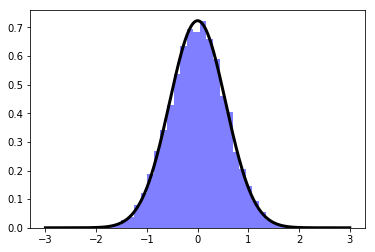

In [109]:
plt.hist(rho1hist,normed = 1, bins = 32, alpha = 0.5, histtype='stepfilled', linewidth = 3, color = 'b');
plt.plot(x,  system.rho1(x), linewidth = 3, color = 'k');

In [114]:
sshot = system.singleshot(numshots = 100000)

Estimated Sampling Efficency=78.76%


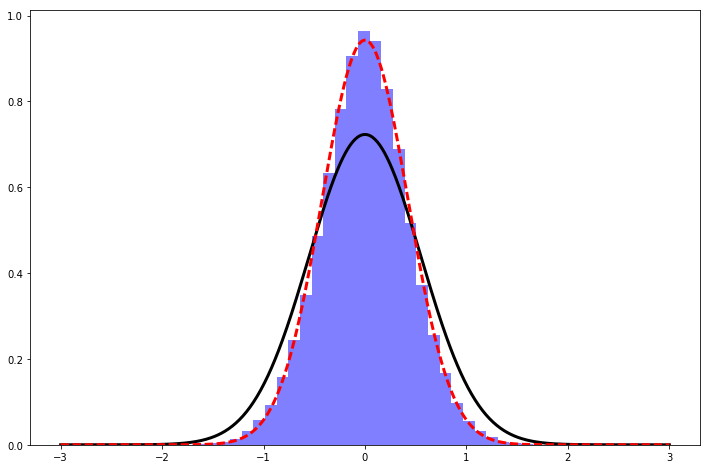

In [90]:
x = np.linspace(-3,3,512,endpoint=True)
plt.subplots(figsize = (12,8))
#plt.hist(sshot.ravel(),normed = 1, bins = 32, alpha = 0.5, histtype='stepfilled', linewidth = 3, color = 'b');
plt.hist(sshot[:,0],normed = 1, bins = 32, alpha = 0.5, histtype='stepfilled', linewidth = 3, color = 'b');
plt.plot(x,  system.rho1(x), linewidth = 3, color = 'k');
plt.plot(x,  system.conditonalP(x,0,2),'--', linewidth = 3, color = 'r');
#plt.plot(x,  system.conditonalP(x,0,3),':', linewidth = 3, color = 'g');
#plt.plot(x,  system.conditonalP(x,0,4),'--', linewidth = 3, color = 'm');

In [32]:
system = HIM(N = 2, omega = 1, lambda0 = 1)
#sshot = system.singleshot(numshots = 10000)
rho2hist = system.rho2hist(numshots = 100000)

Estimated Sampling Efficency=0.00%


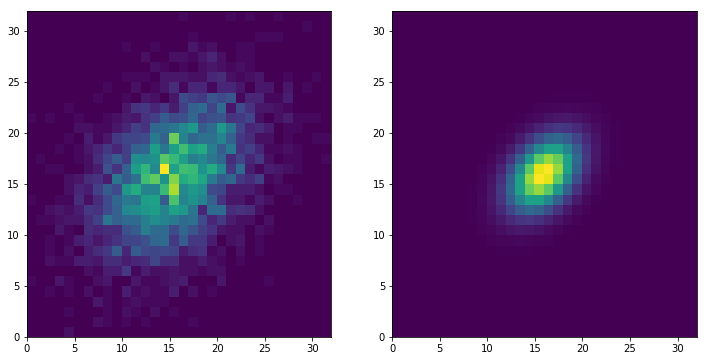

In [34]:
#H, edges = np.histogramdd(sshot, bins = (32,32))
H, edges = np.histogramdd(rho2hist, bins = (32,32))
fig, axs = plt.subplots(1,2,figsize = (12,6))
H = H / len(rho2hist[:,0])
axs[0].pcolor(H)        
xvec = np.linspace(-4,4,32,endpoint=True)
Pxy = np.zeros((len(xvec),len(xvec)))
for i,x in enumerate(xvec):
    for j,xp in enumerate(xvec):
        Pxy[i,j] = system.rho2(x,xp)
#[X1,X2] = np.meshgrid(x,x)
axs[1].pcolor(Pxy);


In [33]:
rho2hist.shape

(4201, 2)

In [180]:
type(rho2hist)

numpy.ndarray

In [9]:
sum(sum(H))

1.0000000000000004

In [10]:
sum(sum(Pxy))*(xvec[1]-xvec[0])**2

0.99999999806722628

In [ ]:
H, xedges, yedges = np.histogram2d(, y, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.
plt.pcolor(H/)

In [61]:
sshot.shape

(76663, 2)

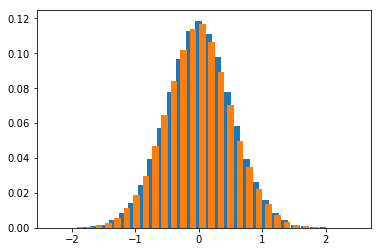

In [47]:
hist, bins = np.histogram(sshot[:,0], density=False, bins = 32)

width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
hist_size = sum(hist)
plt.bar(center, hist/hist_size, align='center', width=width);

hist, bins = np.histogram(sshot[:,1], density=False, bins = 32)

width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
hist_size = sum(hist)
plt.bar(center, hist/hist_size, align='center', width=width);

#sshot_2_rho = sshot[:,0]*sum(sshot[:,1])/sshot.shape[0]

In [53]:
sum(hist/np.sqrt(hist_size))*0.14821015

41.078014583402926

In [52]:
np.diff(bins)

array([ 0.14821015,  0.14821015,  0.14821015,  0.14821015,  0.14821015,
        0.14821015,  0.14821015,  0.14821015,  0.14821015,  0.14821015,
        0.14821015,  0.14821015,  0.14821015,  0.14821015,  0.14821015,
        0.14821015,  0.14821015,  0.14821015,  0.14821015,  0.14821015,
        0.14821015,  0.14821015,  0.14821015,  0.14821015,  0.14821015,
        0.14821015,  0.14821015,  0.14821015,  0.14821015,  0.14821015,
        0.14821015,  0.14821015])

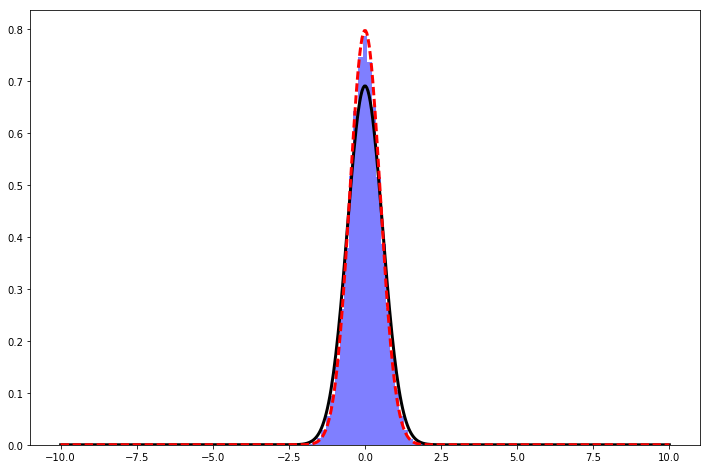

In [19]:
plt.subplots(figsize = (12,8))
#plt.hist(sshot[:,0],normed = 1, bins = 32, alpha = 0.5, histtype='stepfilled', linewidth = 3, color = 'b');
#plt.plot(x,  system.rho1(x), linewidth = 3, color = 'k');
#plt.plot(x,  system.conditonalP(x,0,2),'--', linewidth = 3, color = 'r');

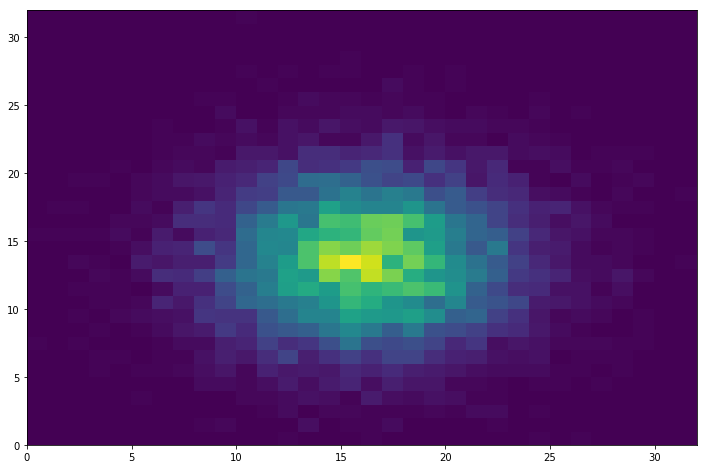

In [56]:
#x = np.random.random_sample(1000)
#y = np.random.random_sample(1000)
x = np.random.randn(10000)
y = np.random.randn(10000)
H, xedges, yedges = np.histogram2d(x, y, bins=(32, 32))
H = H.T  # Let each row list bins with common y range.

fig = plt.figure(figsize=(12, 8))
plt.pcolor(H);

In [61]:
[X,Y] = np.meshgrid(x,y)
P = 1/(1 * np.sqrt(2 * np.pi)) * np.exp( - (X - 0)**2 / (2 * 1**2)) *1/(1 * np.sqrt(2 * np.pi)) * np.exp( - (Y - 0)**2 / (2 * 1**2)) 
plt.pcolor(P);

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/shachar/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-9c3c40ee6a24>", line 1, in <module>
    [X,Y] = np.meshgrid(x,y)
  File "/home/shachar/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py", line 4116, in meshgrid
    return [x * mult_fact for x in output]
  File "/home/shachar/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py", line 4116, in <listcomp>
    return [x * mult_fact for x in output]
MemoryError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/shachar/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 1821, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'MemoryError' object has no attribute '_render_traceback_'

During handling of the above exceptio

MemoryError: 